# Hypothesis 1

There is a relation between EEG signal and 3 levels of stress.

For each pair of person and task, there are 3 distinct groups of EEG signals representing the 3 levels of stress.

In [12]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, StandardScaler

In [2]:
# start : begin of question
# T: answer correct
# F: answer incorrect
# S: not answer in time
# O: unexpected key press
marker_names = [0,
            'math,LowStress,start',
            'math,LowStress,T',
            'math,LowStress,F',
            'math,LowStress,S',
            'math,LowStress,O',
            'math,MildStress,start',
            'math,MildStress,T',
            'math,MildStress,F',
            'math,MildStress,S',
            'math,MildStress,O',
            'math,HigherStress,start',
            'math,HigherStress,T',
            'math,HigherStress,F',
            'math,HigherStress,S',
            'math,HigherStress,O',
            'fixation,None,None']

In [3]:
task = "mathcontrol" 
# task = "mathstress"

files = glob(f"data/*_{task}_*.csv")
names = []
pd_raws = []
raws = []
with tqdm(files) as pbar:
    for index, f in enumerate(pbar):
        name, task, t_stamp = f.split('/')[1].split('_')
        names.append(name)
        pbar.set_description(f"{index} {name}")
        pd_raw = pd.read_csv(f, dtype={'Marker':str})
        pd_raw = marker_converter(pd_raw,marker_names)
        pd_raws.append(pd_raw)

print(f"index\tname\tfile_name")
print("="*30)
for index in range(len(names)):
    print(f"{index}\t{names[index]}\t{files[index]}")

  0%|          | 0/7 [00:00<?, ?it/s]

index	name	file_name
0	nuttasit	data/nuttasit_mathcontrol_2021-08-12-07.51.14.csv
1	nutcha	data/nutcha_mathcontrol_2021-08-10-12.00.36.csv
2	krittithee	data/krittithee_mathcontrol_2021-08-13-04.23.39.csv
3	surangrat	data/surangrat_mathcontrol_2021-08-12-04.52.16.csv
4	dusadee	data/dusadee_mathcontrol_2021-08-12-06.23.55.csv
5	prin	data/prin_mathcontrol_2021-08-13-06.18.47.csv
6	pumpath	data/pumpath_mathcontrol_2021-08-12-03.03.11.csv


In [4]:
with tqdm(pd_raws) as pbar:
    for index, pd_raw in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        marker = pd_raw['Marker']
        print(f"Participant:'{names[index]}'")
        print(f"Number of LowStress: {sum(marker == marker_names.index('math,LowStress,start'))}")
        print(f"\tcorrect: {sum(marker == marker_names.index('math,LowStress,T'))}")
        print(f"\tincorrect: {sum(marker == marker_names.index('math,LowStress,F'))}")
        print(f"\tslow: {sum(marker == marker_names.index('math,LowStress,S'))}")
        print(f"\tout of range: {sum(marker == marker_names.index('math,LowStress,O'))}")

        print(f"Number of MildStress: {sum(marker == marker_names.index('math,MildStress,start'))}")
        print(f"\tcorrect: {sum(marker == marker_names.index('math,MildStress,T'))}")
        print(f"\tincorrect: {sum(marker == marker_names.index('math,MildStress,F'))}")
        print(f"\tslow: {sum(marker == marker_names.index('math,MildStress,S'))}")
        print(f"\tout of range: {sum(marker == marker_names.index('math,MildStress,O'))}")
        
        print(f"Number of HigherStress: {sum(marker == marker_names.index('math,HigherStress,start'))}")
        print(f"\tcorrect: {sum(marker == marker_names.index('math,HigherStress,T'))}")
        print(f"\tincorrect: {sum(marker == marker_names.index('math,HigherStress,F'))}")
        print(f"\tslow: {sum(marker == marker_names.index('math,HigherStress,S'))}")
        print(f"\tout of range: {sum(marker == marker_names.index('math,HigherStress,O'))}")
        print(f"="*30)

        marker[marker == marker_names.index('math,LowStress,T')] = 0
        marker[marker == marker_names.index('math,LowStress,F')] = 0
        marker[marker == marker_names.index('math,LowStress,S')] = 0
        marker[marker == marker_names.index('math,LowStress,O')] = 0

        marker[marker == marker_names.index('math,MildStress,T')] = 0
        marker[marker == marker_names.index('math,MildStress,F')] = 0
        marker[marker == marker_names.index('math,MildStress,S')] = 0
        marker[marker == marker_names.index('math,MildStress,O')] = 0

        marker[marker == marker_names.index('math,HigherStress,T')] = 0
        marker[marker == marker_names.index('math,HigherStress,F')] = 0
        marker[marker == marker_names.index('math,HigherStress,S')] = 0
        marker[marker == marker_names.index('math,HigherStress,O')] = 0
        # break

  0%|          | 0/7 [00:00<?, ?it/s]

Participant:'nuttasit'
Number of LowStress: 79
	correct: 15
	incorrect: 1
	slow: 0
	out of range: 0
Number of MildStress: 34
	correct: 7
	incorrect: 0
	slow: 0
	out of range: 0
Number of HigherStress: 20
	correct: 3
	incorrect: 2
	slow: 0
	out of range: 0
Participant:'nutcha'
Number of LowStress: 51
	correct: 17
	incorrect: 1
	slow: 0


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

	out of range: 0
Number of MildStress: 25
	correct: 9
	incorrect: 2
	slow: 0
	out of range: 0
Number of HigherStress: 9
	correct: 3
	incorrect: 0
	slow: 0
	out of range: 0
Participant:'krittithee'
Number of LowStress: 47
	correct: 7
	incorrect: 3
	slow: 0
	out of range: 0
Number of MildStress: 21
	correct: 0
	incorrect: 0


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

	slow: 0
	out of range: 0
Number of HigherStress: 10
	correct: 1
	incorrect: 0
	slow: 0
	out of range: 0
Participant:'surangrat'
Number of LowStress: 58
	correct: 12
	incorrect: 0
	slow: 0


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

	out of range: 0
Number of MildStress: 38
	correct: 9
	incorrect: 2
	slow: 0
	out of range: 0
Number of HigherStress: 17
	correct: 3
	incorrect: 0
	slow: 0
	out of range: 0


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

Participant:'dusadee'
Number of LowStress: 28
	correct: 4
	incorrect: 0
	slow: 0
	out of range: 0
Number of MildStress: 9
	correct: 1
	incorrect: 0
	slow: 0
	out of range: 0
Number of HigherStress: 6
	correct: 1
	incorrect: 0
	slow: 0
	out of range: 0
Participant:'prin'
Number of LowStress: 55
	correct: 8
	incorrect: 2


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

	slow: 0
	out of range: 0
Number of MildStress: 37
	correct: 6
	incorrect: 2
	slow: 0
	out of range: 0
Number of HigherStress: 18
	correct: 1
	incorrect: 1
	slow: 0
	out of range: 0
Participant:'pumpath'
Number of LowStress: 40
	correct: 11
	incorrect: 1
	slow: 0
	out of range: 0
Number of MildStress: 20
	correct: 5
	incorrect: 0
	slow: 0


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

	out of range: 0
Number of HigherStress: 10
	correct: 2
	incorrect: 0
	slow: 0
	out of range: 0


<ipython-input-4-7c99ef2912c6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,T')] = 0
<ipython-input-4-7c99ef2912c6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,F')] = 0
<ipython-input-4-7c99ef2912c6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marker[marker == marker_names.index('math,LowStress,S')] = 0
<ipython-inpu

In [5]:
raws = []
sampling_rate = 250 # Hz
with tqdm(pd_raws) as pbar:
    for index,pd_raw in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
        raws.append(raw)

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# Preprocess
for raw in raws:
    raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
    raw.filter(1, None, verbose=False) # Slow drift
    # ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
    # ica.fit(raw, verbose=False)
    # raw = ica.apply(raw, verbose=False)
    pass

In [7]:
interested_marker_names = ['math,LowStress,start','math,MildStress,start','math,HigherStress,start','fixation,None,None']
interested_markers = [ marker_names.index(name) for name in interested_marker_names ]
events_list = []
with tqdm(raws) as pbar:
    for index,raw in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        print(f"Participant:'{names[index]}'")
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
        # marker_names[0] is 0, so skip
        uninterested_markers = list(set(np.unique(events[::,2])).difference(set(interested_markers)))
        for marker in uninterested_markers:
            events = np.delete(events, np.argwhere(events[:,2] == marker), axis=0) 
        events_list.append(events)
        # break

  0%|          | 0/7 [00:00<?, ?it/s]

Participant:'nuttasit'
Participant:'nutcha'
Participant:'krittithee'
Participant:'surangrat'
Participant:'dusadee'
Participant:'prin'
Participant:'pumpath'


In [8]:
# Here we only get the event that indicate the begining of the block and fixation.
interested_events_list = []
with tqdm(events_list) as pbar:
    for index, events in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        interested_events = []
        prev_is_Low_start = False
        prev_is_Mil_start = False
        prev_is_Hig_start = False
        Low_start = marker_names.index('math,LowStress,start')
        Mil_start = marker_names.index('math,MildStress,start')
        Hig_start = marker_names.index('math,HigherStress,start')

        for event in events:
            if(event[2] == Low_start and prev_is_Low_start == False):
                interested_events.append(list(event))
                prev_is_Low_start = True
            elif(event[2] != Low_start):
                prev_is_Low_start = False

            if(event[2] == Mil_start and prev_is_Mil_start == False):
                interested_events.append(list(event))
                prev_is_Mil_start = True
            elif(event[2] != Mil_start):
                prev_is_Mil_start = False

            if(event[2] == Hig_start and prev_is_Hig_start == False):
                interested_events.append(list(event))
                prev_is_Hig_start = True
            elif(event[2] != Hig_start):
                prev_is_Hig_start = False


            if(event[2] == marker_names.index('fixation,None,None')):
                interested_events.append(list(event))
            # print(event)
        interested_events = np.array(interested_events)
        interested_events_list.append(interested_events)

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# Here we split the block into chuncks
chunck_size = 5 # second
chunck_events_list = []
num_chunck = None
with tqdm(interested_events_list) as pbar:
    for index, interested_events in enumerate(pbar):
        m_start = interested_events[0::2]
        m_stop = interested_events[1::2]
        chunck_events = []
        for index, (start, stop) in enumerate(zip(m_start, m_stop)):
            # [time_stamp, _, marker]
            a = start[2] in interested_markers
            b = stop[2] == marker_names.index('fixation,None,None')
            if((a and b) == False):
                raise ValueError(f"at {index}, found unexpected marker order. start='{marker_names[start[2]]}' stop='{marker_names[stop[2]]}'")
            for i in range(start[0], start[0]+(30*250)+1, chunck_size*250):
                if(i + chunck_size*250 >= stop[0]):
                    raise ValueError(f"start stop is incorrect.")
                chunck_events.append([i,0,start[2]])

        chunck_events = np.array(chunck_events)
        chunck_events_list.append(chunck_events)
        num_low = sum(chunck_events[::,2] == marker_names.index('math,LowStress,start'))
        num_mil = sum(chunck_events[::,2] == marker_names.index('math,MildStress,start'))
        num_hig = sum(chunck_events[::,2] == marker_names.index('math,HigherStress,start'))
        if(num_low != num_mil or num_mil != num_hig):
            raise ValueError(f"The number of chuncked events is not equal. LowStress={num_low} MildStress={num_mil} HigherStress={num_hig}")
        print(f"Number of samples of each block: {num_low}")
        num_chunck = num_low


  0%|          | 0/7 [00:00<?, ?it/s]

Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28


In [10]:
# 0,4 Delta
# 4,8 Theta
# 8,16 Alpha ***
# 16,32 Beta 
# 32,64 Noisy Gamma
# 64,128 Noisy Signal
# frequencies = np.arange(8, 32+1, 8)

frequencies = np.array([10,11,12,13,14])
t_start, t_stop = 0.3, 4.8
features_list = []
labels_list = []
with tqdm(raws) as pbar:
    for index_1, raw in enumerate(pbar):
        pbar.set_description(f"{index_1} {names[index_1]}")
        raw, chunck_events = raws[index_1], chunck_events_list[index_1]
        features = []
        labels = []
        epochs = mne.Epochs(raw, chunck_events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)

        for index, evoked in enumerate(epochs.iter_evoked()):
            event = evoked.comment
            tfr_obj = mne.time_frequency.tfr_morlet(evoked, n_cycles=3, return_itc=False, freqs=frequencies, decim=3)
            # (channel,freq,time-window)
            coeff = tfr_obj.data 
            # (freq,time-window)
            coeff = coeff.mean(axis=0)
            # alpha mean
            coeff = coeff.mean()
            features.append(coeff)
            labels.append(event)
        features_list.append(features)
        labels_list.append(labels)
# features = np.array(features)
# features.shape

  0%|          | 0/7 [00:00<?, ?it/s]

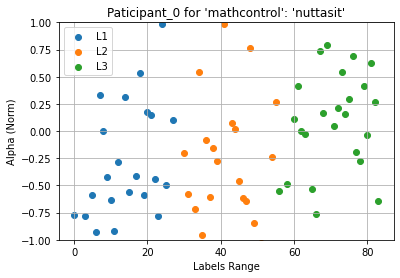

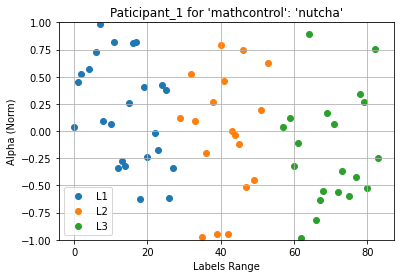

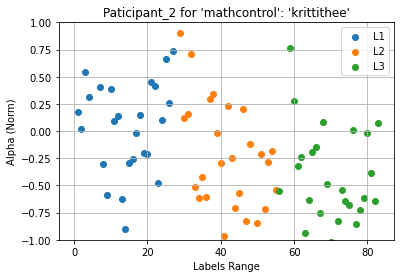

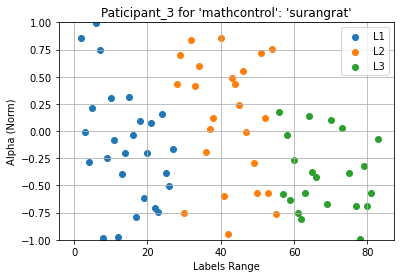

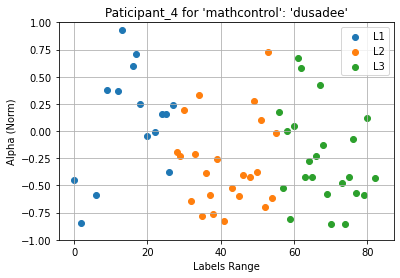

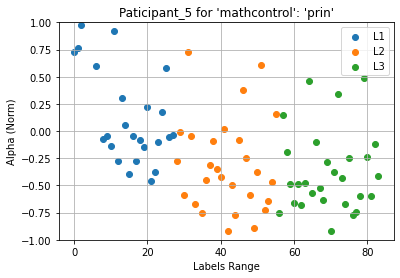

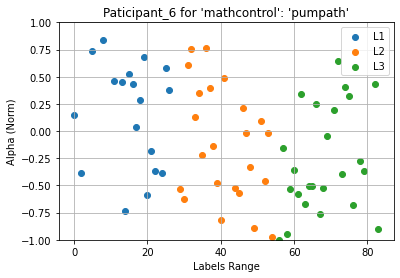

In [19]:
for index, features in enumerate(features_list):
    fig,ax = plt.subplots(1,1)
    # f_norm = normalize(np.array(features).reshape(-1,1), axis=0, norm='max')
    scaler = StandardScaler()
    f_norm = scaler.fit_transform(np.array(features).reshape(-1,1))
    # StandardScaler
    # f_norm = np.array(features).reshape(-1,1)
    ax.scatter(range(num_chunck*0,num_chunck*1),f_norm[num_chunck*0:num_chunck*1], label="L1")
    ax.scatter(range(num_chunck*1,num_chunck*2),f_norm[num_chunck*1:num_chunck*2], label="L2")
    ax.scatter(range(num_chunck*2,num_chunck*3),f_norm[num_chunck*2:num_chunck*3], label="L3")
    ax.set_title(f"Paticipant_{index} for '{task}': '{names[index]}'")
    ax.set_xlabel("Labels Range")
    ax.set_ylabel("Alpha (Norm)")
    ax.legend()
    ax.grid()
    ax.set_ylim(-1,1)
    plt.show()